# CD8 Depletion scRNA-Seq Analysis
## Author: Sarah Kate Nyquist

Data collected by Hannah Gideon, Kush Patel, and Caylin Winchell under PI's JoAnne Flynn and Lin Ling

And by Marc Wadsworth, Travis Hughes, and Roisin Floyd under PI Alex Shalek

In [1]:
import scanpy as sc
import anndata
import os
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import umap
import importlib
import sys
sys.path.insert(0,"../helper_code")
import plotting_helpers
import seaborn as sns

plt.rcParams["figure.figsize"]=(6,6)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
print("Scanpy version " + sc.__version__)
print("UMAP version " + umap.__version__)
print("Pandas version " +pd.__version__)
print("Numpy version "+np.__version__)

Scanpy version 1.7.2
UMAP version 0.5.1
Pandas version 1.1.5
Numpy version 1.19.2


In [84]:
def new_adata_from_raw(adata, cluster_values, cluster_key="leiden"):
    adata_0 = anndata.AnnData(adata[adata.obs[cluster_key].isin(cluster_values)].raw.X)
    adata_0.obs_names = adata[adata.obs[cluster_key].isin(cluster_values)].obs_names
    adata_0.var_names = adata[adata.obs[cluster_key].isin(cluster_values)].raw.var_names
    adata_0.obs = adata[adata.obs[cluster_key].isin(cluster_values)].obs
    adata_0.raw = adata_0
    return adata_0
def propegate_labels_up(sub_adata, parent_adata, sub_colname, parent_colname):
    parent_adata.obs[parent_colname]=parent_adata.obs[parent_colname].astype(str)
    
    parent_adata.obs.loc[sub_adata.obs_names, parent_colname] = sub_adata.obs[sub_colname]

In [2]:
adata=sc.read_h5ad("/data/cb/scratch/nyquist/deeper_sequencing_analysis/analysis_objects/all_grans_nodubs.h5ad")


In [88]:
mac_harm = new_adata_from_raw(adata, ['Macrophages/Monocytes'],cluster_key='nodub subclusters')


In [89]:
import scanpy.external as sce

In [90]:
mac_harm.raw = mac_harm
sc.pp.filter_genes(mac_harm,min_cells=5)
sc.pp.highly_variable_genes(mac_harm, n_top_genes=2000, batch_key="M.Number") # peaked at 256 GB in RAM for finding these genes
mac_harm.var["highly_variable"].loc[["CD3D","ETS1","IFITM1"]]= False
mac_harm.var["highly_variable"].loc[["CD14"]]= True

mac_harm=mac_harm[:,mac_harm.var["highly_variable"]]


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_c

In [91]:
sc.pp.scale(mac_harm, max_value=10)
sc.tl.pca(mac_harm, svd_solver='arpack')
sce.pp.harmony_integrate(mac_harm, "M.Number")

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2023-07-14 21:55:41,093 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-07-14 21:56:02,588 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-07-14 21:56:02,896 - harmonypy - INFO - Iteration 1 of 10
2023-07-14 21:56:13,158 - harmonypy - INFO - Iteration 2 of 10
2023-07-14 21:56:23,467 - harmonypy - INFO - Iteration 3 of 10
2023-07-14 21:56:33,921 - harmonypy - INFO - Iteration 4 of 10
2023-07-14 21:56:44,270 - harmonypy - INFO - Iteration 5 of 10
2023-07-14 21:56:50,167 - harmonypy - INFO - Iteration 6 of 10
2023-07-14 21:56:54,696 - harmonypy - INFO - Converged after 6 iterations


In [92]:
sc.pp.neighbors(mac_harm, n_neighbors=10, n_pcs=22,use_rep="X_pca_harmony")
sc.tl.umap(mac_harm)

In [93]:
sc.tl.leiden(mac_harm,resolution=0.7,key_added="leiden_res0.7")

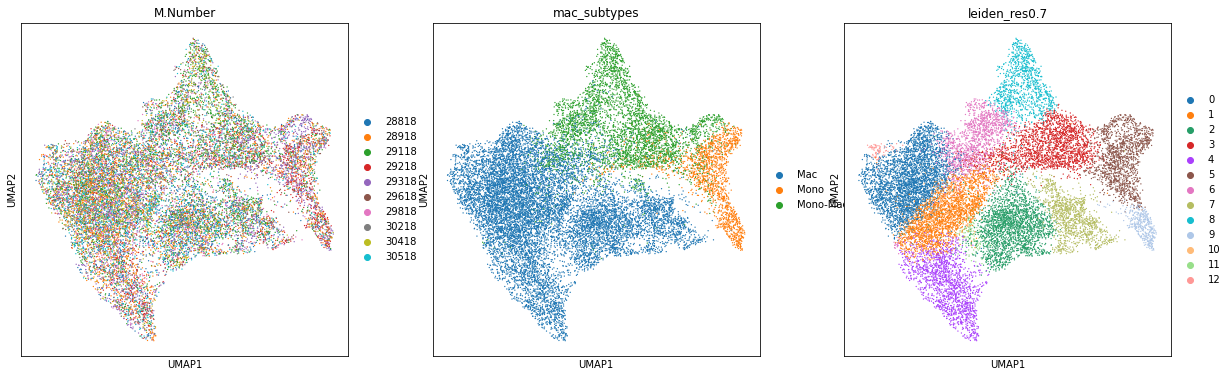

In [94]:
sc.pl.umap(mac_harm, color=["M.Number","mac_subtypes","leiden_res0.7"])

In [96]:
sc.tl.leiden(mac_harm,resolution=0.9,key_added="leiden_res0.9")

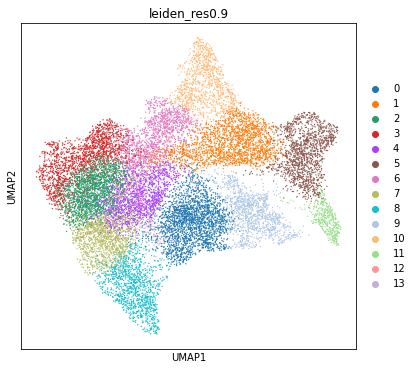

In [97]:
sc.pl.umap(mac_harm, color=["leiden_res0.9"])

In [98]:
sc.tl.leiden(mac_harm,resolution=1.1,key_added="leiden_res1.1")

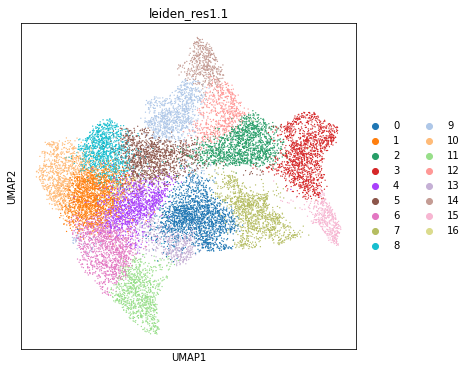

In [99]:
sc.pl.umap(mac_harm, color=["leiden_res1.1"])

In [100]:
sc.tl.rank_genes_groups(mac_harm, "leiden_res0.7")

In [105]:
pd.DataFrame(mac_harm.uns["rank_genes_groups"]["names"])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,C1QB,LOC102129822,ETS1,IDO1,ALDH2,CFP,CTSH,ETS1,IDO1,LOC102140945,APOE,APOE,APOE
1,LOC102130734,APOE,APOE,PPA1,LOC102129811,S100A4,ADAMDEC1,PTPRC,GAPDH,ITGB2,MX1,rna76578,C1QB
2,LGMN,LGALS3,CD3D,PLAC8,RMDN3,FCN1,CTSC,IFITM1,CP,CFD,MX2,GPNMB,MS4A7
3,C1QC,GPX1,IFITM1,FAM26F,MARCO,C9H10orf54,FAM26F,FAM46C,SERPINA1,ITGA4,IFI6,rna76576,C1QC
4,APOE,PRDX1,FAM46C,RARRES3,MRC1,GLIPR2,LILRB4,CORO1A,SNX10,LOC102120967,OAS2,FABP5,LOC102140106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29761,FLNA,ETS1,MEFV,FABP5,VEGFA,APOE,CORO1A,PPARG,GPR34,CD36,SLCO4A1,ZNF776,OXLD1
29762,VCAN,FCN1,DYSF,CCL18,LOC102127482,PLXDC2,S100A4,FABP5,CPVL,TMEM176A,ADAMTS14,ABHD17B,WDYHV1
29763,GLIPR2,RASGRP1,EMILIN2,PLA2G2D,TSPAN33,SLCO2B1,FAM65B,APOC1,CD36,RAB13,NRG1,CDC42EP4,LOC102146611
29764,WARS,FAM65B,VCAN,AHNAK2,F13A1,APOC1,FCN1,GPNMB,CFD,VSIG4,SYN1,DNAJC16,TC2N


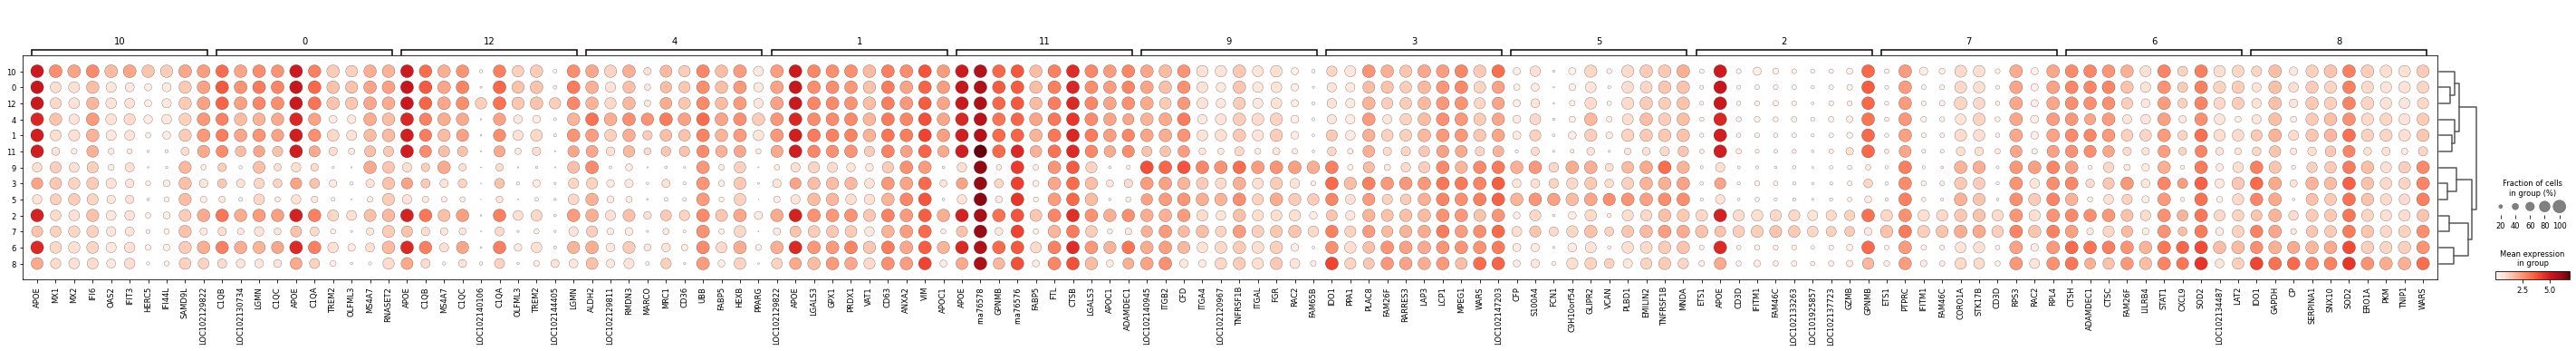

In [106]:
sc.pl.rank_genes_groups_dotplot(mac_harm, groupby="leiden_res0.7")

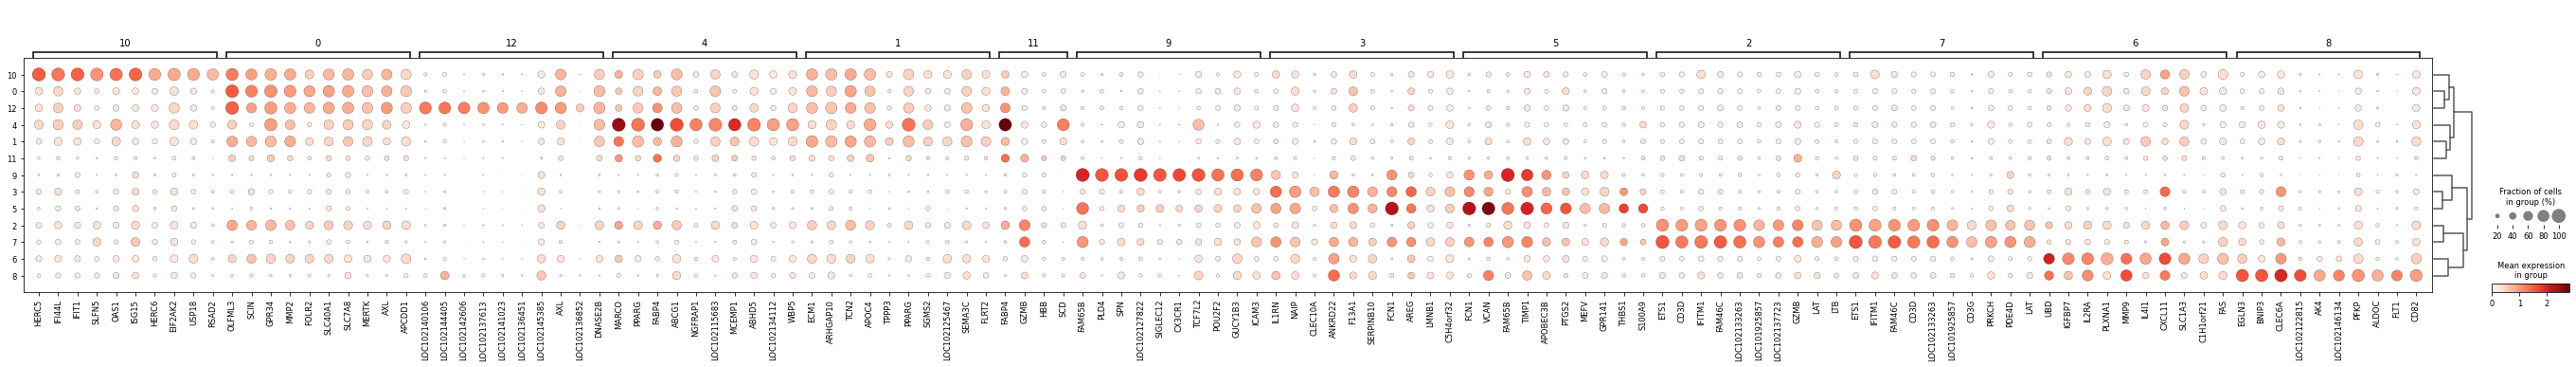

In [109]:
sc.tl.filter_rank_genes_groups(mac_harm)
sc.pl.rank_genes_groups_dotplot(mac_harm,groupby="leiden_res0.7", key="rank_genes_groups_filtered")

In [114]:
labels = {"0":"Mac","1":"Mac","2":"Mac","3":"Inflam.Mac","4":"Alv.Mac","5":"Monocyte","6":"Inflam.Mac","7":"Monocyte","8":"Inflam.Mac","9":"Monocyte","10":"Mac","11":"Mac","12":"Mac"}
mac_harm.obs["mac_clusts"]=mac_harm.obs["leiden_res0.7"].map(labels)


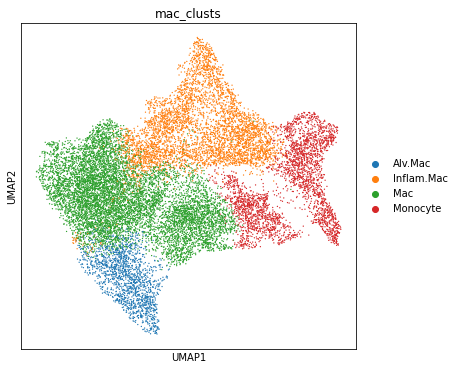

In [117]:
sc.pl.umap(mac_harm,color="mac_clusts",show=False)
plt.savefig("mac_integrated_subclusters.png",bbox_inches="tight")

In [ ]:
sc.pl.dotplot(mac_harm,"IL15",groupby="mac_clusts")

In [118]:
sc.tl.rank_genes_groups(mac_harm,groupby="mac_clusts")

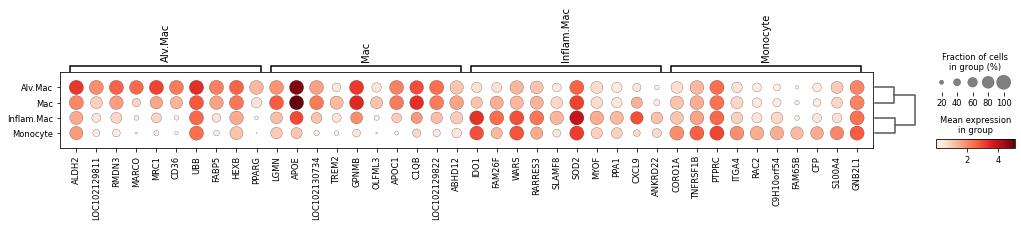

In [119]:
sc.pl.rank_genes_groups_dotplot(mac_harm)

In [41]:
sc.tl.filter_rank_genes_groups(mac_harm)

In [38]:
mac_harm

AnnData object with n_obs × n_vars = 17489 × 1998
    obs: 'sample', 'batch', 'doublet_scores', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'M.Number', 'treatment', 'infection dose', 'Tissue name', 'CFU/granuloma', 'total thoracic CFU', 'Array', 'lung region', 'Gran State', 'total_cells_elbow', 'treatment_monkey_array', 'n_counts', 'n_genes', 'leiden', 'gran_celltypes', 'mac/neut/dc celltypes', 'mac_subtypes', 'umap_density_treatment', 'integrated_clusters', 'myeloid_clusts', 'cNMF_components_1', 'cNMF_components_2', 'cNMF_components_3', 'cNMF_components_4', 'cNMF_components_5', 'cNMF_components_6', 'cNMF_components_7', 'cNMF_components_8', 'cNMF_components_9', 'cNMF_components_10', 'cNMF_components_11', 'cNMF_components_12', 'cNMF_components_13', 'max usage', 'leiden_res0.7', 'leiden_re

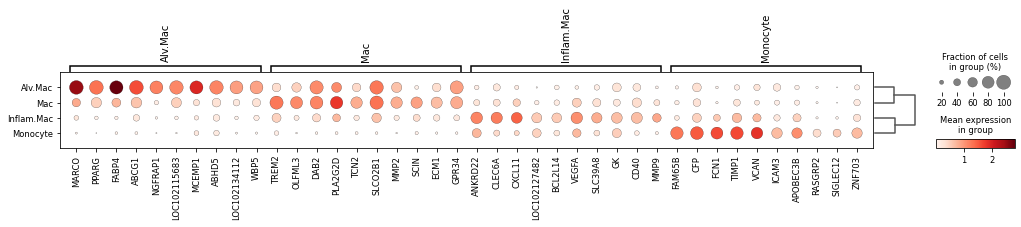

In [121]:
sc.pl.rank_genes_groups_dotplot(mac_harm,key="rank_genes_groups_filtered",show=False)
plt.savefig("mac_subcluster_markergenes.pdf",bbox_inches="tight")

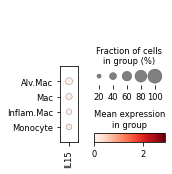

In [52]:
sc.pl.dotplot(mac_harm, ["IL15"],groupby="mac_clusts",dot_max=1,vmin=0,vmax=2.9, categories_order=["Alv.Mac","Mac","Inflam.Mac","Monocyte"],show=False)
plt.savefig("mac_IL15_all.pdf",bbox_inches="tight")

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


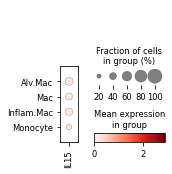

In [53]:
sc.pl.dotplot(mac_harm[mac_harm.obs["treatment"]=="IgG"], ["IL15"],groupby="mac_clusts",dot_max=1,vmin=0,vmax=2.9, categories_order=["Alv.Mac","Mac","Inflam.Mac","Monocyte"],show=False)
plt.savefig("mac_IL15_IgG.pdf",bbox_inches="tight")

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


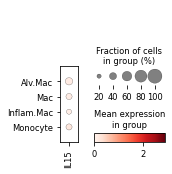

In [54]:
sc.pl.dotplot(mac_harm[mac_harm.obs["treatment"]=="CD8a"], ["IL15"],groupby="mac_clusts",dot_max=1,vmin=0,vmax=2.9, categories_order=["Alv.Mac","Mac","Inflam.Mac","Monocyte"],show=False)
plt.savefig("mac_IL15_CD8A.pdf",bbox_inches="tight")

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


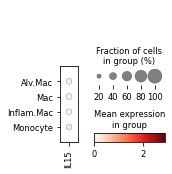

In [55]:
sc.pl.dotplot(mac_harm[mac_harm.obs["treatment"]=="CD8b"], ["IL15"],groupby="mac_clusts",dot_max=1,vmin=0,vmax=2.9, categories_order=["Alv.Mac","Mac","Inflam.Mac","Monocyte"],show=False)
plt.savefig("mac_IL15_CD8B.pdf",bbox_inches="tight")

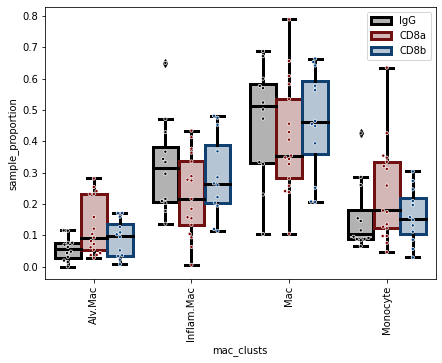

In [123]:
cph.boxplot_sample_proportions(mac_harm, "sample", "mac_clusts",figsize=(7,5),hue_order=["IgG","CD8a","CD8b"],edgecolor=True)
plt.savefig("mac_boxplot_sample_proportions.pdf",bbox_inches="tight")

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


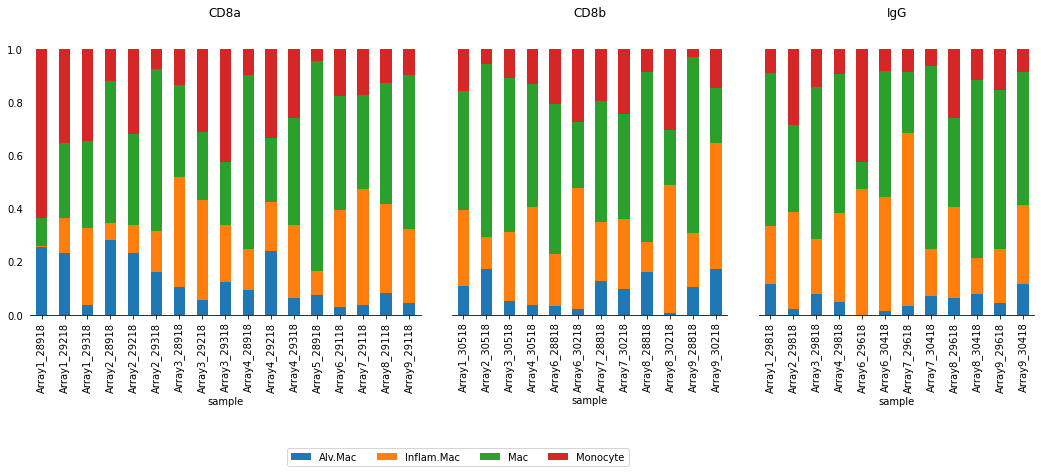

In [127]:
cph.grouped_stacked_bars(mac_harm,"treatment", color_value="mac_clusts",x_value="sample")


In [125]:
mac_harm.obs.groupby(["sample","mac_clusts"]).count()["treatment"].unstack().to_csv("mac_subcluster_counts.csv")

In [129]:
mac_harm.write_h5ad("mono_mac_harmony_integrated.h5ad")

In [29]:
mac_harm= sc.read_h5ad("mono_mac_harmony_integrated.h5ad")